# Similaridade Partidária

## Análise dos discursos parlamentares

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lendo a base de dados
ano = '2019'
df = pd.read_csv('discursos/discursos_preprocessados_2019.csv', sep=";", encoding="utf-8")
df.head()

,Data,Sessão,Fase,Discurso,Hora,Publicação,NomeOrador,Partido,Estado,TextoDiscurso
0,26/02/2019,17.2019,GRANDE EXPEDIENTE,TextoHTML.asp?etapa=5 &nuSessao=17.2019 &nuQua...,16h44,DCD27/02/2019 PAG. 88,FÁBIO TRAD,PSD,MS,projet resoluca autor quer agradec tod lideran...
1,26/02/2019,17.2019,GRANDE EXPEDIENTE,TextoHTML.asp?etapa=5 &nuSessao=17.2019 &nuQua...,16h40,DCD27/02/2019 PAG. 86,SILVIO COSTA FILHO,PRB,PE,questa quer faz apel exa base art incis ii vis...
2,26/02/2019,17.2019,GRANDE EXPEDIENTE,TextoHTML.asp?etapa=5 &nuSessao=17.2019 &nuQua...,16h40,DCD27/02/2019 PAG. 87,POMPEO DE MATTOS,PDT,RS,quer advert cas contribuint vez aprov reform n...
3,26/02/2019,17.2019,GRANDE EXPEDIENTE,TextoHTML.asp?etapa=5 &nuSessao=17.2019 &nuQua...,16h40,DCD27/02/2019 PAG. 86,JULIO CESAR RIBEIRO,PRB,DF,quer diz trist revolt relaca ministr educaca v...
4,26/02/2019,17.2019,GRANDE EXPEDIENTE,TextoHTML.asp?etapa=5 &nuSessao=17.2019 &nuQua...,16h36,DCD27/02/2019 PAG. 85,ÁTILA LIRA,PSB,PI,sra sr parlament quer registr aqu desapont ind...


In [3]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
# Retirados partidos sem representantes ou com apenas um representantes na Câmara 
if(ano == '2010'):
    partidos_com_representantes = ['PT', 'PP', 'CIDADANIA', 'PCDOB', 'PMN', 'MDB', 'DEM', 'PSB', 'PDT', 'PTB', 'PL', 'PSDB', 'PV', 'PSC', 
                 'PAN', 'PTC', 'PHS', 'PSOL', 'PRONA'] # Retirado PTDOB E PRB por terem somente um representante
elif(ano in ['2011', '2012', '2013', '2014']):
    partidos_com_representantes = ['PT', 'MDB', 'PL', 'PSB', 'PDT', 'PSC', 'PCDOB', 'REPUBLICANOS', 'PODE', 'PSDB', 'DEM', 'PTB', 'CIDADANIA', 
                 'PMN', 'AVANTE', 'PP', 'PV', 'PSOL', 'PHS', 'PRTB', 'PRP'] # Retirado PTC e PSL por terem somente um representante
elif(ano in ['2015', '2016', '2017', '2018']):
    partidos_com_representantes = ['PT', 'MDB', 'PL', 'PDT', 'REPUBLICANOS', 'PROS', 'PSD', 'PP', 'PSDB', 'DEM', 'PTB', 'PMN', 'SD', 'PTC', 'PODE', 
                'PATRI', 'PSB', 'PRP', 'CIDADANIA', 'PHS', 'PV', 'PSOL', 'PSC', 'DC', 'PCDOB'] # Retirado PCdoB, PRTB e PSL por terem somente um representante
elif(ano == '2019'):
    partidos_com_representantes = ['PT', 'PSL', 'PP', 'MDB', 'PSD', 'PL', 'PSB', 'PRB', 'PSDB', 'DEM', 'PDT', 'SD', 'PODE', 'PTB', 'PSOL', 
                'PCDOB', 'PSC', 'PROS', 'CIDADANIA', 'NOVO', 'AVANTE', 'PHS', 'PATRI', 'PV', 'PRP', 'PMN', 'PTC'] # Retirados DC, PPL e REDE por terem somente um representante


### TF-IDF term frequency–inverse document frequency

In [5]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000
)
tfidf.fit(df['TextoDiscurso'])
text = tfidf.transform(df['TextoDiscurso'])

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['TextoDiscurso'])
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(),columns=tfidf_vectorizer.get_feature_names())
df_tfidf['Parlamentar'] = df['NomeOrador'].tolist()
df_tfidf['Partido'] = df['Partido'].tolist()
df_tfidf = df_tfidf.reindex(['Partido', 'Parlamentar'] + list(df_tfidf.columns[:-2]), axis=1)
df_tfidf.head()

,Partido,Parlamentar,aa,aacd,aara,aba,abad,abaf,abaix,abal,...,zequ,zer,zeza,zik,zomb,zon,zoolog,zootecn,zouain,zygmunt
0,PSD,FÁBIO TRAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PRB,SILVIO COSTA FILHO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PDT,POMPEO DE MATTOS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PRB,JULIO CESAR RIBEIRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PSB,ÁTILA LIRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Singular-value decomposition (SVD) para redução de dimensionalidade
Uma aplicação popular de SVD é para redução de dimensionalidade.

Dados com um grande número de recursos, como mais recursos (colunas) do que observações (linhas), podem ser reduzidos a um subconjunto menor de recursos que são mais relevantes para o problema de previsão.

O resultado é uma matriz com uma classificação inferior que se aproxima da matriz original.

Para fazer isso, podemos realizar uma operação SVD nos dados originais e selecionar os k maiores valores singulares no Sigma. Essas colunas podem ser selecionadas de Sigma e as linhas selecionadas de V ^ T.

In [7]:
from numpy import array
from sklearn.decomposition import TruncatedSVD
A = text
# svd
svd = TruncatedSVD(n_components=2)
svd.fit(A)
text = svd.transform(A)

## Similaridade por Clusterização

### Medição através de clusterização com DBSCAN
O DBSCANalgoritmo vê os clusters como áreas de alta densidade separadas por áreas de baixa densidade. Devido a essa visão um tanto genérica, os clusters encontrados pelo DBSCAN podem ter qualquer formato, ao contrário de k-means, que assume que os clusters têm formato convexo. O componente central do DBSCAN é o conceito de amostras de núcleo , que são amostras que estão em áreas de alta densidade. Um cluster é, portanto, um conjunto de amostras de núcleo, cada uma próxima uma da outra (medida por alguma medida de distância) e um conjunto de amostras não essenciais que estão perto de uma amostra de núcleo (mas não são elas próprias amostras de núcleo). Existem dois parâmetros para o algoritmo, min_samplese eps, que definem formalmente o que queremos dizer quando dizemos denso . Superior min_samplesou inferioreps indicam maior densidade necessária para formar um cluster.

In [8]:
agrupador_dbscan = DBSCAN(eps=1.0, min_samples=5).fit(text)
labels_dbscan = agrupador_dbscan.fit_predict(text)

#print("O coeficiente de silhueta do DBSCAN é: ", silhouette_score(text, labels_dbscan))
#print("Labels DBSCAN: ", labels_dbscan)

### Medição através de clusterização com K-Means

O k-means é o mais popular e mais simples algoritmo particional. K-means foi descoberto independentemente em diferentes campos científicos, primeiramente por STEINHAUS (1956), LLOYD (1982), BALL & HALL (1965) e MACQUEEN (1967) e mesmo tendo sido proposto há mais de 50 anos, ainda é um dos algoritmos mais utilizados para clusterização devido à facilidade de implementação, simplicidade, eficiência e sucesso empírico e possui várias extensões desenvolvidas em várias formas

### Melhorando a aplicação do algoritmo K-Means

O <b>método cotovelo</b> ajuda a encontrar o melhor valor de k. Ele usa a soma das distâncias quadradas [SSE] entre os pontos de dados e seus respectivos centróides ou médias de cluster atribuídos. Em seguida, selecione o valor k na posição em que o SSE começa a achatar e formar um cotovelo.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


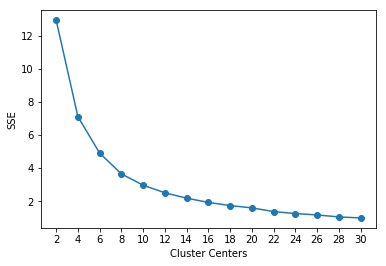

In [9]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    #ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

Devido ao gráfico gerado pelo método de cotovelo não formar uma curva acentuada seguida por estabilidade no eixo y, optamos por utilizar a quantidade de partidos com representantes como o número de clusters (k)

In [10]:
#k = len(partidos_com_representantes)
k = 10
print("Atribuído", k, "clusters.")

Atribuído 10 clusters.


In [11]:
clusters = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=12).fit_predict(text)

In [12]:
agrupador_kmeans = KMeans(n_clusters = k)
labels_kmeans = agrupador_kmeans.fit_predict(text)

print("O coeficiente de silhueta do K-means é: ", silhouette_score(text, labels_kmeans))
#print("Labels Kmeans: ", labels_kmeans)

O coeficiente de silhueta do K-means é:  0.3476310637371833


Selecionando os valores dos 2 maiores clusters

In [13]:
labels = labels_kmeans

df['NomeOrador'] = df['NomeOrador'].replace([' ASSIS CARVALHO (PRESIDENTE)'], ' ASSIS CARVALHO')
clusters_parlamentar = pd.crosstab(df["NomeOrador"], labels)
# removendo partidos com apenas 1 discurso
#clusters_parlamentar = clusters_parlamentar[clusters_parlamentar.sum(axis=1) > 1]
print(clusters_parlamentar.shape)
p_partidos = []
for p in clusters_parlamentar.index:
    p_partidos.append(df.query('NomeOrador=="'+p+'"')['Partido'][:1].tolist()[0])
clusters_parlamentar['Partido'] = p_partidos
clusters_parlamentar.reset_index(inplace=True)
clusters_parlamentar = clusters_parlamentar.reindex(['Partido'] + list(clusters_parlamentar.columns[:-2]), axis=1)
clusters_parlamentar.head()

(270, 10)


col_0,Partido,NomeOrador,0,1,2,3,4,5,6,7,8
0,PSL,ABOU ANNI,0,0,0,0,0,0,0,0,2
1,NOVO,ADRIANA VENTURA,0,0,0,0,0,1,0,0,0
2,PT,AFONSO FLORENCE,1,0,0,0,0,1,0,0,1
3,PP,AFONSO HAMM,3,0,2,0,0,0,0,0,0
4,PDT,AFONSO MOTTA,1,0,0,0,0,0,0,0,1


In [14]:
import heapq
dfc = clusters_parlamentar.groupby(['Partido']).sum()
dfc=dfc.reset_index()
lst = dfc.values.tolist()
partido = []
soma_2_k = []
soma_total = []
score = []
anos = []
clusteres = []
cluster1 = []
vlrcluster1 = []
cluster2 = []
vlrcluster2 = []
novo_score = []
for i in lst:
    # se o partido tiver 5 ou mais discursos
    if(sum(i[1:]) >= 5):
        # Selecionando os valores dos 2 maiores clusters
        valores = heapq.nlargest(2,i[1:])
        
        # Selecionando o cluster pelos maiores valores
        klusters = ''
        pos1 = i.index(valores[0])
        pos2 = i.index(valores[1])
        # Se houver o mesmo valor em mais de um cluster
        if(pos1 == pos2):
            pos1 = [k for k, item in enumerate(i) if item == valores[0]][0]
            pos2 = [k for k, item in enumerate(i) if item == valores[0]][1]
        klusters = "k" + str(pos1) + ": " + str(valores[0]) + " - k" + str(pos2) + ": "+ str(valores[1])
        cluster1.append(pos1)
        vlrcluster1.append(valores[0])
        cluster2.append(pos2)
        vlrcluster2.append(valores[1])
        partido.append(i[0])
        soma_2_k.append(sum(valores))
        soma_total.append(sum(i[1:]))
        score.append(sum(valores)/sum(i[1:]))
        anos.append(ano)
        clusteres.append(klusters)
        
        # cálculo do indicador
        # (n*(t1+t2)-2*t)/(n*t-2*t)
        n = k
        t1 = valores[0]
        t2 = valores[1]
        t = sum(i[1:])
        vl_score = (n*(t1+t2)-2*t)/(n*t-2*t)
        novo_score.append(round(vl_score,2))
df_score_clusters = pd.DataFrame()
df_score_clusters['Ano'] = anos
df_score_clusters['Partido'] = partido
df_score_clusters['soma_2_clusters'] = soma_2_k
df_score_clusters['soma_total'] = soma_total
df_score_clusters['Percentual'] = score
df_score_clusters['Score_GE'] = novo_score
#df_score_clusters['Clusteres'] = clusteres
df_score_clusters['Cluster1'] = cluster1
df_score_clusters['VlrCluster1'] = vlrcluster1
df_score_clusters['Cluster2'] = cluster2
df_score_clusters['VlrCluster2'] = vlrcluster2
df_score_clusters['ScoreClusterUnico'] = df_score_clusters['VlrCluster1']/df_score_clusters['soma_total']
df_score_clusters

,Ano,Partido,soma_2_clusters,soma_total,Percentual,Score_GE,Cluster1,VlrCluster1,Cluster2,VlrCluster2,ScoreClusterUnico
0,2019,AVANTE,4,6,0.666667,0.58,3,2,9,2,0.333333
1,2019,CIDADANIA,7,17,0.411765,0.26,9,4,3,3,0.235294
2,2019,DEM,8,18,0.444444,0.31,1,4,8,4,0.222222
3,2019,MDB,14,28,0.500000,0.38,3,8,7,6,0.285714
4,2019,NOVO,7,12,0.583333,0.48,9,4,4,3,0.333333
5,2019,PCDOB,18,38,0.473684,0.34,3,9,7,9,0.236842
6,2019,PDT,14,39,0.358974,0.20,3,8,1,6,0.205128
7,2019,PL,13,26,0.500000,0.38,9,8,7,5,0.307692
8,2019,PODE,10,18,0.555556,0.44,6,6,9,4,0.333333
9,2019,PP,11,23,0.478261,0.35,3,7,7,4,0.304348


[Text(0, 0.5, 'Densidade'),
 Text(0.5, 0, 'ICPD'),
 Text(0.5, 1.0, 'Densidade do Índice de Coesão sobre Discursos')]

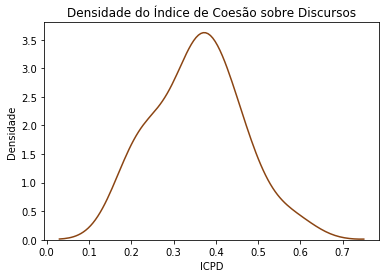

In [15]:
import seaborn as sns
ax = sns.distplot(df_score_clusters['Score_GE'], bins=10, kde=True, hist=False, color='#8B4513')
ax.set(xlabel='ICPD', ylabel='Densidade', title='Densidade do Índice de Coesão sobre Discursos')

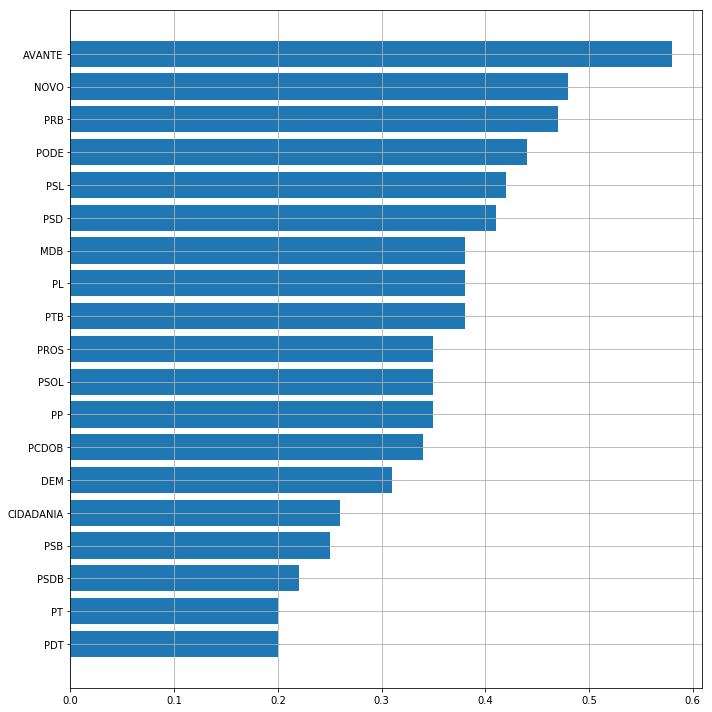

In [16]:
df_score_clusters = df_score_clusters.sort_values(['Score_GE'])
fig = plt.figure(figsize=(10,10))
plt.barh(df_score_clusters['Partido'], df_score_clusters['Score_GE'])
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
partido = []
parlamentar = []
cluster1 = []
cluster2 = []
total_d = []
for x,y,z in zip(df_score_clusters['Partido'],df_score_clusters['Cluster1'],df_score_clusters['Cluster2']):
    df_k_parlamentar = clusters_parlamentar.query("Partido=='"+x+"'")
    for a, b, c in zip(df_k_parlamentar['NomeOrador'], df_k_parlamentar[(y -1)], df_k_parlamentar[(z -1)]):
        #print(x, a,"|",y,"->",b,"|",z,"->",c)
        parlamentar.append(a)
        partido.append(x)
        cluster1.append(b)
        cluster2.append(c)
        ss = clusters_parlamentar.query('NomeOrador=="'+a+'"')
        ss.drop(['Partido', 'NomeOrador'], axis=1, inplace=True)
        total_d.append(ss.values.sum())
df_deputado_k = pd.DataFrame()
df_deputado_k['Partido'] = partido
df_deputado_k['Parlamentar'] = parlamentar
df_deputado_k['Cluster1'] = cluster1
df_deputado_k['Cluster2'] = cluster2
df_deputado_k['Total'] = total_d

df_deputado_k['ICPD'] = (df_deputado_k['Cluster1'] + df_deputado_k['Cluster2']) / df_deputado_k['Total']
df_deputado_k.head()

/Users/Polato/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Partido,Parlamentar,Cluster1,Cluster2,Total,ICPD
0,PDT,AFONSO MOTTA,0,1,2,0.500000
1,PDT,CHICO D'ANGELO,0,1,3,0.333333
2,PDT,FLAVIO NOGUEIRA,0,0,0,NaN
3,PDT,FÁBIO HENRIQUE,2,1,6,0.500000
4,PDT,FÉLIX MENDONÇA JÚNIOR,0,0,1,0.000000


In [18]:
df_deputado_k.to_csv('score/score_parlamentar_2019.csv', sep=';', index=False)

In [19]:
df_score_clusters.to_csv('score/score_ge_2019.csv', sep=';', index=False)

AVANTE


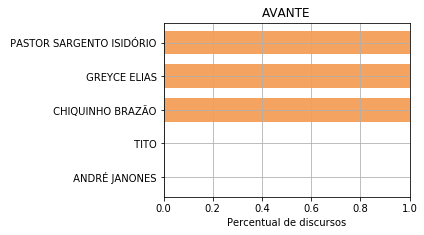

CIDADANIA


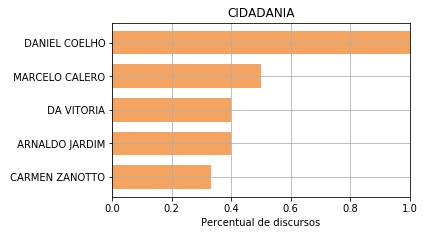

DEM


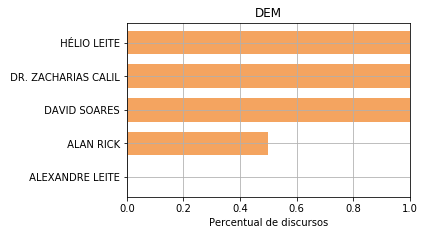

MDB


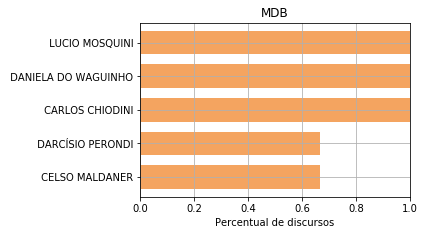

NOVO


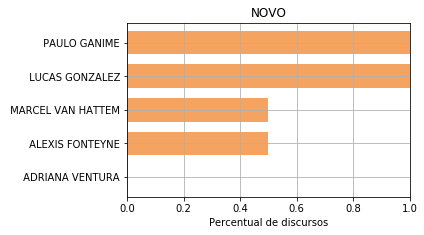

PCDOB


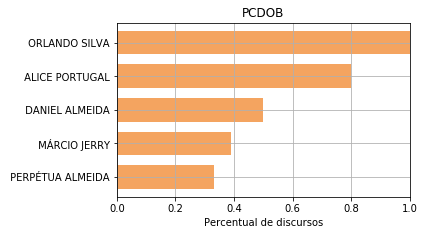

PDT


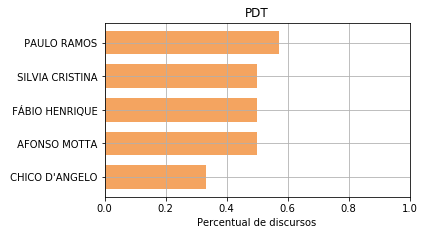

PL


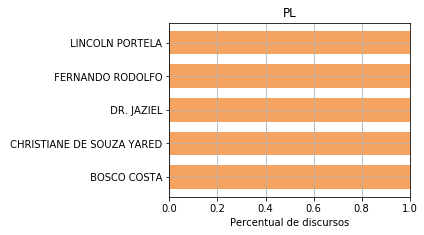

PODE


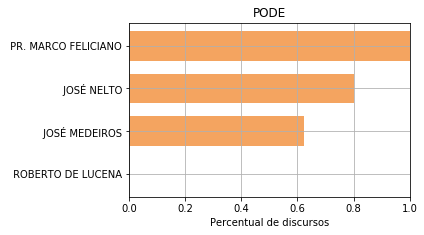

PP


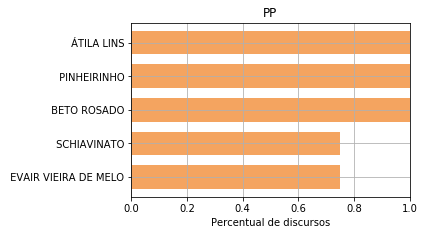

PRB


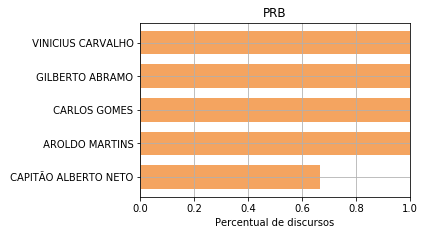

PROS


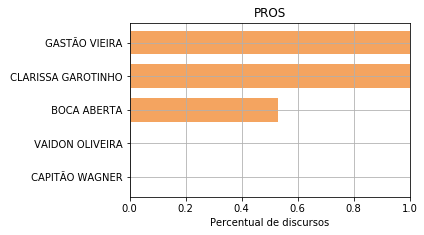

PSB


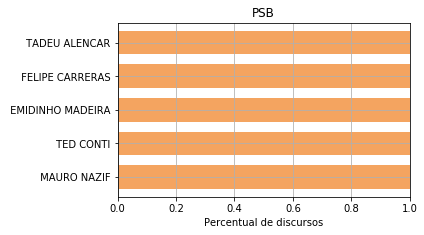

PSD


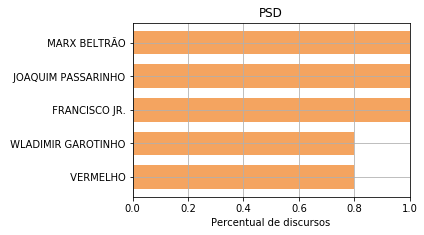

PSDB


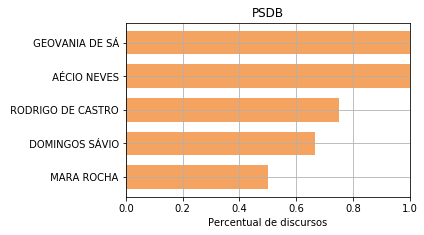

PSL


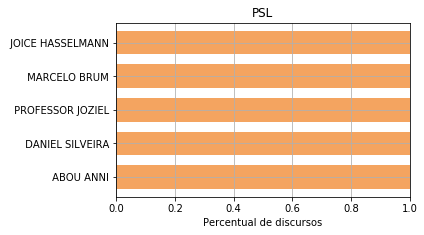

PSOL


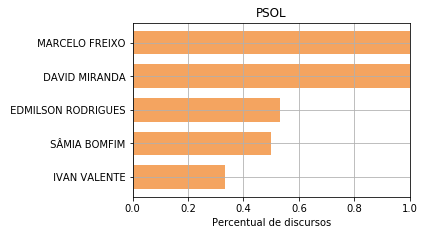

PT


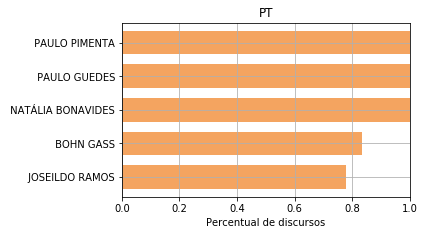

PTB


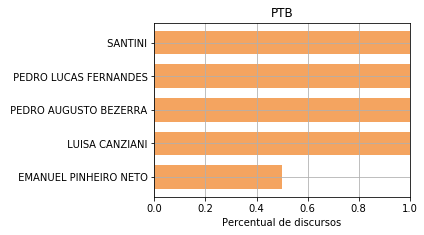

In [20]:
for i in sorted(df_score_clusters.Partido.tolist()):
    dfk = df_deputado_k.query('Partido=="'+i+'"').sort_values(['ICPD'], ascending=False)[:5]
    dfk = dfk.sort_values(['ICPD'], ascending=True)
    print(i)
    width = 0.7
    fig = plt.figure(figsize=(6,3))
    plt.barh(dfk['Parlamentar'], dfk['ICPD'], width, color='#F4A460')
    plt.grid()
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.title(i)
    plt.xlabel('Percentual de discursos')
    plt.show()

In [42]:
p = "PSL"
df_deputado_k.query("Partido in ['"+p+"']").sort_values(['ICPD'], ascending = False)

,Partido,Parlamentar,Cluster1,Cluster2,Total,ICPD
197,PSL,ABOU ANNI,0,2,2,1.000000
212,PSL,DANIEL SILVEIRA,2,1,3,1.000000
235,PSL,PROFESSOR JOZIEL,2,0,2,1.000000
233,PSL,MARCELO BRUM,0,1,1,1.000000
228,PSL,JOICE HASSELMANN,1,0,1,1.000000
226,PSL,GURGEL,0,1,1,1.000000
223,PSL,GENERAL GIRÃO,1,1,2,1.000000
222,PSL,FILIPE BARROS,2,1,3,1.000000
219,PSL,ENÉIAS REIS,3,0,3,1.000000
214,PSL,DELEGADO MARCELO FREITAS,1,0,1,1.000000
